In [1]:
import pandas as pd

df = pd.read_csv("creditcard.csv")
print(df.shape)
print(df['Class'].value_counts())
print(df.isnull().sum())

(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# Step 1: Features (X) and Target (y)
X = df.drop('Class', axis=1)  # all columns except 'Class'
y = df['Class']               # target column

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)



Train shape: (227845, 30) (227845,)
Test shape: (56962, 30) (56962,)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Copy so we don’t overwrite original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale Amount and Time columns if they exist
for col in ['Amount', 'Time']:
    if col in X_train.columns:
        X_train_scaled[col] = scaler.fit_transform(X_train[[col]])
        X_test_scaled[col] = scaler.transform(X_test[[col]])

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
 [[55478  1386]
 [    8    90]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



In [10]:
import numpy as np

# Get predicted probabilities for fraud class
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    from sklearn.metrics import precision_score, recall_score
    print(f"Threshold: {t:.1f} -> Precision: {precision_score(y_test, y_pred_thresh):.3f}, Recall: {recall_score(y_test, y_pred_thresh):.3f}")


Threshold: 0.1 -> Precision: 0.008, Recall: 0.949
Threshold: 0.2 -> Precision: 0.016, Recall: 0.939
Threshold: 0.3 -> Precision: 0.027, Recall: 0.918
Threshold: 0.4 -> Precision: 0.042, Recall: 0.918
Threshold: 0.5 -> Precision: 0.061, Recall: 0.918
Threshold: 0.6 -> Precision: 0.087, Recall: 0.908
Threshold: 0.7 -> Precision: 0.121, Recall: 0.908
Threshold: 0.8 -> Precision: 0.161, Recall: 0.898


In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=4))


[[56861     3]
 [   25    73]]
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962



Matplotlib is building the font cache; this may take a moment.


PR AUC: 0.760


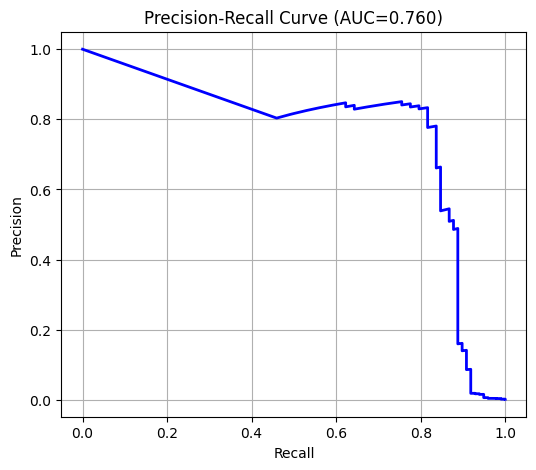

In [12]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the fraud class
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute area under PR curve
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.3f}")

# Plot
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC={pr_auc:.3f})')
plt.grid(True)
plt.show()
